In [ ]:
# Instalação de Bibliotecas
pip install pandas numpy matplotlib scikit-learn tensorflow keras seaborn optuna

In [1]:
# Importação de Bibliotecas
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.neural_network import MLPClassifier

import optuna

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, SpatialDropout1D, SimpleRNN, Embedding
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

c:\Users\ana_v\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Carregar os dados
df = pd.read_csv("C:/Users/ana_v/OneDrive/Documentos/Repositórios/TCGA.csv", low_memory=False)

# Obtém os valores únicos na coluna 'Type'
unique_types = df['Type'].unique()

# Cria um dicionário mapeando cada tipo único para um número
type_to_numeric = {type_name: index for index, type_name in enumerate(unique_types)}

# Aplica a substituição usando o método map
df['Type'] = df['Type'].map(type_to_numeric)

# Armazena a coluna 'Type' para adicioná-la de volta posteriormente
type_column = df['Type']

# Prepara o DataFrame para normalização (remover colunas desnecessárias)
df_num = df.drop(columns=["Sample", "Type"])

# Normalizar os dados
scaler = StandardScaler()
dados_normalizados = scaler.fit_transform(df_num)

# Aplicação do PCA
pca = PCA(n_components=0.8)  
pca.fit(dados_normalizados)
dados_pca = pca.transform(dados_normalizados)

In [3]:
# Fixar a seed para garantir a reprodutibilidade
seed = 1

# Divisão de treino e teste com random_state
X_train, X_test, y_train, y_test = train_test_split(dados_pca, df['Type'], test_size=0.2, random_state=seed)

# Função objetivo para otimização do SVM
def objective_svm(trial):
    svc_c = trial.suggest_loguniform('svc_c', 1e-5, 1e2)
    svc_kernel = trial.suggest_categorical('svc_kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    
    model_svm = SVC(C=svc_c, kernel=svc_kernel, random_state=seed)
    score = cross_val_score(model_svm, X_train, y_train, cv=10, scoring='accuracy').mean()
    return score

# Função objetivo para otimização do Random Forest
def objective_rf(trial):
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 200)
    rf_max_depth = trial.suggest_int('rf_max_depth', 10, 50)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 20)
    
    model_rf = RandomForestClassifier(n_estimators=rf_n_estimators, max_depth=rf_max_depth,
                                      min_samples_split=rf_min_samples_split, random_state=seed)
    score = cross_val_score(model_rf, X_train, y_train, cv=10, scoring='accuracy').mean()
    return score

# Função objetivo para otimização da Regressão Logística
def objective_lr(trial):
    lr_c = trial.suggest_loguniform('lr_c', 1e-5, 1e2)
    lr_solver = trial.suggest_categorical('lr_solver', ['newton-cg', 'lbfgs', 'liblinear', 'saga'])
    
    model_lr = LogisticRegression(C=lr_c, solver=lr_solver, max_iter=10000, random_state=seed)
    score = cross_val_score(model_lr, X_train, y_train, cv=10, scoring='accuracy').mean()
    return score

# Estudo e otimização com Optuna para SVM
study_svm = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=seed))
study_svm.optimize(objective_svm, n_trials=10)
best_params_svm = study_svm.best_params
print("Melhores parâmetros para SVM:", best_params_svm)

# Estudo e otimização com Optuna para Random Forest
study_rf = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=seed))
study_rf.optimize(objective_rf, n_trials=10)
best_params_rf = study_rf.best_params
print("Melhores parâmetros para Random Forest:", best_params_rf)

# Estudo e otimização com Optuna para Regressão Logística
study_lr = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=seed))
study_lr.optimize(objective_lr, n_trials=10)
best_params_lr = study_lr.best_params
print("Melhores parâmetros para Regressão Logística:", best_params_lr)

[I 2024-09-04 14:54:54,332] A new study created in memory with name: no-name-701ed36b-e094-4ec1-a2f5-9c62d2592260
C:\Users\ana_v\AppData\Local\Temp\ipykernel_2060\376960319.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  svc_c = trial.suggest_loguniform('svc_c', 1e-5, 1e2)
[I 2024-09-04 14:54:55,239] Trial 0 finished with value: 0.7284684684684686 and parameters: {'svc_c': 0.008301451461243867, 'svc_kernel': 'linear'}. Best is trial 0 with value: 0.7284684684684686.
C:\Users\ana_v\AppData\Local\Temp\ipykernel_2060\376960319.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  svc_c = trial.suggest_loguniform('svc_c', 1e-5, 1e2)
[I 2024-09-04 14:54:55,933] Trial 1 fin

Melhores parâmetros para SVM: {'svc_c': 83.56561666138207, 'svc_kernel': 'rbf'}


[I 2024-09-04 14:55:21,451] Trial 0 finished with value: 0.7165225225225226 and parameters: {'rf_n_estimators': 112, 'rf_max_depth': 39, 'rf_min_samples_split': 2}. Best is trial 0 with value: 0.7165225225225226.
[I 2024-09-04 14:55:36,019] Trial 1 finished with value: 0.7125225225225226 and parameters: {'rf_n_estimators': 95, 'rf_max_depth': 16, 'rf_min_samples_split': 3}. Best is trial 0 with value: 0.7165225225225226.
[I 2024-09-04 14:55:48,169] Trial 2 finished with value: 0.7231531531531532 and parameters: {'rf_n_estimators': 78, 'rf_max_depth': 24, 'rf_min_samples_split': 9}. Best is trial 2 with value: 0.7231531531531532.
[I 2024-09-04 14:56:08,230] Trial 3 finished with value: 0.7192612612612612 and parameters: {'rf_n_estimators': 131, 'rf_max_depth': 27, 'rf_min_samples_split': 15}. Best is trial 2 with value: 0.7231531531531532.
[I 2024-09-04 14:56:22,454] Trial 4 finished with value: 0.7165045045045044 and parameters: {'rf_n_estimators': 80, 'rf_max_depth': 46, 'rf_min_sampl

Melhores parâmetros para Random Forest: {'rf_n_estimators': 196, 'rf_max_depth': 22, 'rf_min_samples_split': 15}


[I 2024-09-04 14:58:05,515] Trial 0 finished with value: 0.7793153153153154 and parameters: {'lr_c': 0.008301451461243867, 'lr_solver': 'newton-cg'}. Best is trial 0 with value: 0.7793153153153154.
C:\Users\ana_v\AppData\Local\Temp\ipykernel_2060\376960319.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr_c = trial.suggest_loguniform('lr_c', 1e-5, 1e2)
[I 2024-09-04 14:59:17,750] Trial 1 finished with value: 0.7887387387387388 and parameters: {'lr_c': 4.429657657076251e-05, 'lr_solver': 'saga'}. Best is trial 1 with value: 0.7887387387387388.
C:\Users\ana_v\AppData\Local\Temp\ipykernel_2060\376960319.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr_c = tria

Melhores parâmetros para Regressão Logística: {'lr_c': 4.429657657076251e-05, 'lr_solver': 'saga'}


In [4]:
# Treinar e avaliar o modelo SVM com os melhores parâmetros
best_model_svm = SVC(C=best_params_svm['svc_c'], kernel=best_params_svm['svc_kernel'], random_state=seed)
best_model_svm.fit(X_train, y_train)
svm_predictions_train = best_model_svm.predict(X_train)
svm_predictions_test = best_model_svm.predict(X_test)

# Avaliação SVM
svm_accuracy_train = accuracy_score(y_train, svm_predictions_train)
svm_accuracy_test = accuracy_score(y_test, svm_predictions_test)
svm_report = classification_report(y_test, svm_predictions_test, zero_division=1)

# Resultados
print(f'SVM - Acurácia (Teste): {svm_accuracy_test}')
print(f'Acurácia média na validação cruzada: {cross_val_score(best_model_svm, X_train, y_train, cv=10).mean()}')
print(f'\nClassification Report (SVM):\n{svm_report}')
print("Matriz de Confusão:\n", confusion_matrix(y_test, svm_predictions_test))

SVM - Acurácia (Teste): 0.7754010695187166
Acurácia média na validação cruzada: 0.7766666666666667

Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.82      0.93      0.88        90
           1       0.64      0.61      0.62        41
           2       0.85      0.90      0.88        31
           3       0.70      0.33      0.45        21
           4       0.33      0.25      0.29         4

    accuracy                           0.78       187
   macro avg       0.67      0.61      0.62       187
weighted avg       0.76      0.78      0.76       187

Matriz de Confusão:
 [[84  4  1  1  0]
 [13 25  1  2  0]
 [ 1  2 28  0  0]
 [ 1  8  3  7  2]
 [ 3  0  0  0  1]]


In [13]:
# Treinar e avaliar o modelo Random Forest com os melhores parâmetros
best_model_rf = RandomForestClassifier(
    n_estimators=best_params_rf['rf_n_estimators'],
    max_depth=best_params_rf['rf_max_depth'],
    min_samples_split=best_params_rf['rf_min_samples_split'],
    random_state=seed
)
best_model_rf.fit(X_train, y_train)
rf_predictions_train = best_model_rf.predict(X_train)
rf_predictions_test = best_model_rf.predict(X_test)

# Avaliação Random Forest
rf_accuracy_train = accuracy_score(y_train, rf_predictions_train)
rf_accuracy_test = accuracy_score(y_test, rf_predictions_test)
rf_report = classification_report(y_test, rf_predictions_test, zero_division=1)

print(f'Random Forest - Acurácia (Teste): {rf_accuracy_test}')
print(f'Acurácia média na validação cruzada: {cross_val_score(best_model_rf, X_train, y_train, cv=10).mean()}')
print(f'\nClassification Report (Random Forest):\n{rf_report}')
print("Matriz de Confusão:\n", confusion_matrix(y_test, rf_predictions_test))

Random Forest - Acurácia (Teste): 0.6951871657754011
Acurácia média na validação cruzada: 0.7258918918918918

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.69      0.92      0.79        90
           1       0.59      0.46      0.52        41
           2       0.80      0.90      0.85        31
           3       1.00      0.00      0.00        21
           4       1.00      0.00      0.00         4

    accuracy                           0.70       187
   macro avg       0.82      0.46      0.43       187
weighted avg       0.73      0.70      0.64       187

Matriz de Confusão:
 [[83  7  0  0  0]
 [21 19  1  0  0]
 [ 2  1 28  0  0]
 [10  5  6  0  0]
 [ 4  0  0  0  0]]


In [6]:
# Treinar e avaliar o modelo Regressão Logística com os melhores parâmetros
best_model_lr = LogisticRegression(
    C=best_params_lr['lr_c'],
    solver=best_params_lr['lr_solver'],
    max_iter=10000,
    random_state=seed
)
best_model_lr.fit(X_train, y_train)
lr_predictions_train = best_model_lr.predict(X_train)
lr_predictions_test = best_model_lr.predict(X_test)

# Avaliação Regressão Logística
lr_accuracy_train = accuracy_score(y_train, lr_predictions_train)
lr_accuracy_test = accuracy_score(y_test, lr_predictions_test)
lr_report = classification_report(y_test, lr_predictions_test)

print(f'Regressão Logística - Acurácia (Teste): {lr_accuracy_test}')
print(f'Acurácia média na validação cruzada: {cross_val_score(best_model_lr, X_train, y_train, cv=10).mean()}')
print(f'\nClassification Report (Regressão Logística):\n{lr_report}')
print("Matriz de Confusão:\n", confusion_matrix(y_test, lr_predictions_test))

c:\Users\ana_v\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ana_v\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ana_v\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Regressão Logística - Acurácia (Teste): 0.7807486631016043
Acurácia média na validação cruzada: 0.7887387387387388

Classification Report (Regressão Logística):
              precision    recall  f1-score   support

           0       0.74      0.98      0.84        90
           1       0.80      0.49      0.61        41
           2       0.85      0.94      0.89        31
           3       1.00      0.43      0.60        21
           4       0.00      0.00      0.00         4

    accuracy                           0.78       187
   macro avg       0.68      0.57      0.59       187
weighted avg       0.79      0.78      0.75       187

Matriz de Confusão:
 [[88  1  1  0  0]
 [20 20  1  0  0]
 [ 2  0 29  0  0]
 [ 6  4  2  9  0]
 [ 3  0  1  0  0]]


In [7]:
# Função objetivo para otimização do MLP
def objective_mlp(trial):
    n_layers = trial.suggest_int('n_layers', 2, 6)
    hidden_layer_sizes = [trial.suggest_int(f'n_units_l{i}', 25, 150) for i in range(n_layers)]
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
    learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-4, 1e-1)
    
    # Criar e treinar o modelo
    model = MLPClassifier(hidden_layer_sizes=tuple(hidden_layer_sizes), activation=activation,
                          solver=solver, alpha=alpha, learning_rate_init=learning_rate_init,
                          max_iter=500, random_state=seed)
    
    # Validação cruzada
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy').mean()
    return score

# Estudo de otimização com Optuna para MLP
study_mlp = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=seed))
study_mlp.optimize(objective_mlp, n_trials=10)

# Melhores parâmetros
best_params_mlp = study_mlp.best_params
print("Melhores parâmetros para MLP:", best_params_mlp)

# Treinamento e avaliação do MLP com os melhores parâmetros
best_mlp_model = MLPClassifier(hidden_layer_sizes=tuple(best_params_mlp[f'n_units_l{i}'] for i in range(best_params_mlp['n_layers'])),
                               activation=best_params_mlp['activation'],
                               solver=best_params_mlp['solver'],
                               alpha=best_params_mlp['alpha'],
                               learning_rate_init=best_params_mlp['learning_rate_init'],
                               max_iter=500, random_state=seed)
best_mlp_model.fit(X_train, y_train)
mlp_predictions_train = best_mlp_model.predict(X_train)
mlp_predictions_test = best_mlp_model.predict(X_test)

# Avaliação do modelo
mlp_accuracy_train = accuracy_score(y_train, mlp_predictions_train)
mlp_accuracy_test = accuracy_score(y_test, mlp_predictions_test)
mlp_report = classification_report(y_test, mlp_predictions_test, zero_division=1)

[I 2024-09-04 15:04:56,010] A new study created in memory with name: no-name-d67b0911-c055-414b-8e4f-94bf723e57e9
C:\Users\ana_v\AppData\Local\Temp\ipykernel_2060\3373024165.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
C:\Users\ana_v\AppData\Local\Temp\ipykernel_2060\3373024165.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-4, 1e-1)
[I 2024-09-04 15:05:01,098] Trial 0 finished with value: 0.5215391498881432 and parameters: {'n_layers': 4, 'n_units_l0': 115, 'n_units_l1': 25, 'n_units_l2': 63, 'n_units_l3': 43, 'activation': 'logistic',

Melhores parâmetros para MLP: {'n_layers': 3, 'n_units_l0': 138, 'n_units_l1': 97, 'n_units_l2': 25, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.04306660168805714, 'learning_rate_init': 0.007414474013266335}


In [8]:
# Avaliação para MLP
print("\nResultados do MLP:")
print("Matriz de Confusão:\n", confusion_matrix(y_test, mlp_predictions_test))
print("Acurácia (Teste):", accuracy_score(y_test, mlp_predictions_test))

# Acurácia média na validação cruzada
cv_mean_score = cross_val_score(best_mlp_model, X_train, y_train, cv=10, scoring='accuracy').mean()
print(f'Acurácia média na validação cruzada (MLP): {cv_mean_score:.4f}')

# Classification Report
print(f'\nClassification Report (MLP):\n{mlp_report}')


Resultados do MLP:
Matriz de Confusão:
 [[82  4  0  2  2]
 [13 26  0  2  0]
 [ 0  1 27  1  2]
 [ 0  7  2 11  1]
 [ 2  0  0  0  2]]
Acurácia (Teste): 0.7914438502673797
Acurácia média na validação cruzada (MLP): 0.7794

Classification Report (MLP):
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        90
           1       0.68      0.63      0.66        41
           2       0.93      0.87      0.90        31
           3       0.69      0.52      0.59        21
           4       0.29      0.50      0.36         4

    accuracy                           0.79       187
   macro avg       0.69      0.69      0.68       187
weighted avg       0.79      0.79      0.79       187



In [9]:
# Definir número de classes
num_classes = len(unique_types)

def create_cnn_model(n_conv_layers=2, n_dense_layers=1, filters=32, kernel_size=3, pool_size=2, dense_units=64, dropout_rate=0.5):
    model = Sequential()

    # Adicionar camadas convolucionais conforme definido por Optuna
    for i in range(n_conv_layers):
        if i == 0:
            model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same', input_shape=(X_train.shape[1], 1)))
        else:
            model.add(Conv1D(filters=filters * (2 ** i), kernel_size=kernel_size, activation='relu', padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(Flatten())

    # Adicionar camadas densas conforme definido por Optuna
    for _ in range(n_dense_layers):
        model.add(Dense(dense_units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    # Camada de saída
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Função objetivo para otimização do CNN com Optuna
def objective_cnn(trial):
    # Hiperparâmetros para CNN
    n_conv_layers = trial.suggest_int('n_conv_layers', 1, 4)  
    n_dense_layers = trial.suggest_int('n_dense_layers', 1, 3) 
    filters = trial.suggest_int('filters', 16, 64)
    kernel_size = trial.suggest_int('kernel_size', 2, 5) 
    pool_size = trial.suggest_int('pool_size', 2, 3) 
    dense_units = trial.suggest_int('dense_units', 32, 128)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
    epochs = trial.suggest_int('epochs', 5, 20)  

    # Criação do modelo
    model = create_cnn_model(n_conv_layers=n_conv_layers,
                             n_dense_layers=n_dense_layers,
                             filters=filters,
                             kernel_size=kernel_size,
                             pool_size=pool_size,
                             dense_units=dense_units,
                             dropout_rate=dropout_rate)

    # Validação cruzada
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    cv_scores = []
    for train_index, val_index in kf.split(X_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
        model.fit(X_fold_train, y_fold_train, epochs=epochs, batch_size=32, verbose=0)
        val_loss, val_accuracy = model.evaluate(X_fold_val, y_fold_val, verbose=0)
        cv_scores.append(val_accuracy)
    # Média da acurácia de validação cruzada
    mean_cv_accuracy = np.mean(cv_scores)

    return mean_cv_accuracy

# Estudo de otimização com Optuna para CNN
study_cnn = optuna.create_study(direction='maximize')
study_cnn.optimize(objective_cnn, n_trials=10)

# Melhores parâmetros
best_params_cnn = study_cnn.best_params
print("Melhores parâmetros para CNN:", best_params_cnn)

# Treinamento e avaliação do CNN com melhores parâmetros
best_cnn_model = create_cnn_model(n_conv_layers=best_params_cnn['n_conv_layers'],
                                  n_dense_layers=best_params_cnn['n_dense_layers'],
                                  filters=best_params_cnn['filters'],
                                  kernel_size=best_params_cnn['kernel_size'],
                                  pool_size=best_params_cnn['pool_size'],
                                  dense_units=best_params_cnn['dense_units'],
                                  dropout_rate=best_params_cnn['dropout_rate'])

# Treinamento do modelo com o melhor número de épocas
history = best_cnn_model.fit(X_train, y_train, epochs=best_params_cnn['epochs'], batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Avaliação da CNN no conjunto de teste
cnn_loss, cnn_accuracy = best_cnn_model.evaluate(X_test, y_test)

# Predições da CNN no conjunto de teste
cnn_predictions = best_cnn_model.predict(X_test)
cnn_predictions_classes = np.argmax(cnn_predictions, axis=1)

# Classification report da CNN
cnn_report = classification_report(y_test, cnn_predictions_classes, target_names=[str(cls) for cls in unique_types], zero_division=1, digits=2)

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, cnn_predictions_classes)

# Acurácia de treinamento
train_accuracy = history.history['accuracy'][-1]

# Acurácia da validação cruzada 
cv_mean_accuracy = study_cnn.best_value

[I 2024-09-04 15:12:29,255] A new study created in memory with name: no-name-69fe1f99-c38e-4e87-afba-1180aa8d9623
C:\Users\ana_v\AppData\Local\Temp\ipykernel_2060\448404244.py:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
c:\Users\ana_v\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2024-09-04 15:13:14,479] Trial 0 finished with value: 0.8572259426116944 and parameters: {'n_conv_layers': 4, 'n_dense_layers': 2, 'filters': 54, 'kernel_size': 4, 'pool_size': 2, 'dense_

Melhores parâmetros para CNN: {'n_conv_layers': 3, 'n_dense_layers': 1, 'filters': 36, 'kernel_size': 4, 'pool_size': 3, 'dense_units': 127, 'dropout_rate': 0.2312004978361033, 'epochs': 12}
Epoch 1/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4216 - loss: 1.6822 - val_accuracy: 0.5080 - val_loss: 1.2766
Epoch 2/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6043 - loss: 1.0926 - val_accuracy: 0.5989 - val_loss: 0.9985
Epoch 3/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6720 - loss: 0.9067 - val_accuracy: 0.6578 - val_loss: 0.8931
Epoch 4/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7176 - loss: 0.7136 - val_accuracy: 0.6684 - val_loss: 0.8410
Epoch 5/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7511 - loss: 0.6409 - val_accuracy: 0.7005 - val_loss: 0.8518
Epoch 6/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7917 - loss: 0.5424 - val_accuracy: 0.6684 - val_loss: 0.9390
Epoch 7/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/s

In [10]:
# Exibindo resultados da CNN
print(f'\nCNN - Acurácia (Treinamento): {train_accuracy:.4f}')
print(f'CNN - Acurácia (Teste): {cnn_accuracy:.4f}')
print(f'Acurácia média na validação cruzada (CNN): {cv_mean_accuracy:.4f}')
print(f'\nMatriz de Confusão (CNN):\n{conf_matrix}')
print(f'\nClassification Report (CNN):\n{cnn_report}')


CNN - Acurácia (Treinamento): 0.9586
CNN - Acurácia (Teste): 0.7005
Acurácia média na validação cruzada (CNN): 0.9160

Matriz de Confusão (CNN):
[[80  9  0  1  0]
 [20 18  1  2  0]
 [ 4  0 26  0  1]
 [ 7  5  3  6  0]
 [ 3  0  0  0  1]]

Classification Report (CNN):
              precision    recall  f1-score   support

        LumA       0.70      0.89      0.78        90
        LumB       0.56      0.44      0.49        41
       Basal       0.87      0.84      0.85        31
        Her2       0.67      0.29      0.40        21
      Normal       0.50      0.25      0.33         4

    accuracy                           0.70       187
   macro avg       0.66      0.54      0.57       187
weighted avg       0.69      0.70      0.68       187



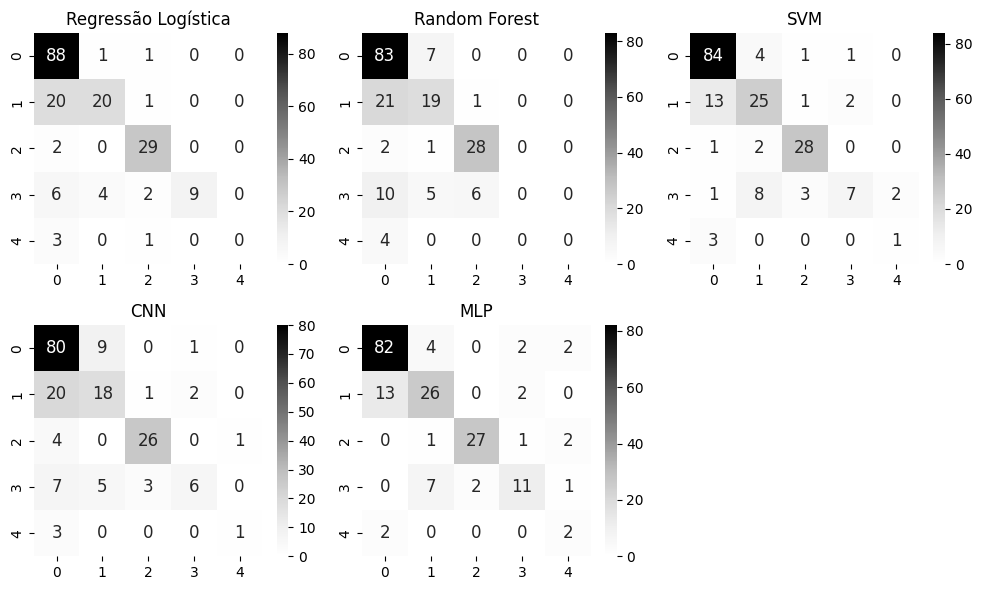

In [12]:
# Definir unique_types e target_names
unique_types = df['Type'].unique()
target_names = [str(cls) for cls in unique_types]

# Matrizes de confusão
conf_matrix_lr = confusion_matrix(y_test, lr_predictions_test)
conf_matrix_rf = confusion_matrix(y_test, rf_predictions_test)
conf_matrix_svm = confusion_matrix(y_test, svm_predictions_test)
conf_matrix_cnn = confusion_matrix(y_test, cnn_predictions_classes)
conf_matrix_mlp = confusion_matrix(y_test, mlp_predictions_test)

# Função para plotar a matriz de confusão em um subplot específico
def plot_confusion_matrix_subplot(ax, conf_matrix, title):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greys', 
                xticklabels=target_names, yticklabels=target_names, 
                annot_kws={"size": 12}, ax=ax)
    ax.set_title(title, fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

# Criar uma figura com subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# Adicionar as matrizes de confusão a cada subplot
plot_confusion_matrix_subplot(axes[0, 0], conf_matrix_lr, 'Regressão Logística')
plot_confusion_matrix_subplot(axes[0, 1], conf_matrix_rf, 'Random Forest')
plot_confusion_matrix_subplot(axes[0, 2], conf_matrix_svm, 'SVM')
plot_confusion_matrix_subplot(axes[1, 1], conf_matrix_mlp, 'MLP')
plot_confusion_matrix_subplot(axes[1, 0], conf_matrix_cnn, 'CNN')

# Remover o último subplot vazio (opcional)
fig.delaxes(axes[1, 2])

# Ajustar o layout
plt.tight_layout()

# Salvar a figura completa com as 5 matrizes de confusão
plt.savefig('all_confusion_matrices_tcga_optuna.png')

# Mostrar a figura
plt.show()